To run this code, create a conda environment like 

`conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel tqdm multiprocessing warnings itertools python=3.9`

Furthermore, reproduce the output directory structure I use with

`xargs mkdir -p < dirs.txt`
I assume that you execute this file from the same directory in which the subdirectories containing the training and evaluation data are saved.

# ForceSMIP: Independent Component Analysis (ICA) reconstruction methods for the forced response
<h4>By Moritz Günther (Max Planck Institute for Meteorology)</h4>

Decomposition of a spatiotemporal field is often achieved by Principal Component Analysis (PCA, or EOF analysis). To reconstruct the forced response from one single realization / observation, Low Frequency Component Analysis (LFCA) was recently proposed, a version of PCA that rotates the basis to find optimal vectors that maximize the ratio of low frequency variance to total variance. However, PCA suffers of some limitations, although some of them are relieved by more sophisticated methods like LFCA. [Monahan et al. 2009](https://doi.org/10.1175/2009JCLI3062.1) state that EOF modes

> "(i) will not correspond to individual dynamical modes,</br>
>  (ii) will not correspond to individual kinematic degrees of freedom,</br>
>  (iii) will not be statistically independent of other EOF modes, and</br>
>  (iv) will be strongly influenced by the nonlocal requirement that modes maximize variance over the entire domain."

Independent Component Analysis (ICA) is a different decomposition technique that can overcome some of these limitations, but is subject to others. The goal of this submission is to explore the potential of ICA for estimating the forced response from single ensemble members. I will partially follow the algorithms and thoughts of the LFCA paper [Wills et al. 2018](https://doi.org/10.1002/2017GL076327) and the code in [the ForceSMIP github repo](https://github.com/karenamckinnon/forcesmiphttps://github.com/karenamckinnon/forcesmip). Just like PCA gives pairs of principal components (PCs) and empirical orthogonal functions (EOFs), ICA gives pairs of independent components (ICs) and independent patterns (IPs). For our application, the IPs are spatial patterns, and the ICs are timeseries associated with the strength of the pattern at each time step.

A detailed explanation of ICA that was very helpful for me can be found in [Hyvärinen and Oja 2000](https://doi.org/10.1016/S0893-6080(00)00026-5), at this point I will just briefly outline the idea. PCA finds pairs of PCs and EOFs maximize the explained variance of the PCs. In contrast, ICA finds pairs of independent components (ICs, the analog to PCs in PCA) and independent patterns (IPs, the anaolog to EOFs in PCA) that maximize independence. Independence is a much stronger constraint than uncorrelatedness. In ICA, one assumes that independence is maximized when the sources are as far away from a Gaussian distribution as possible. This idea is rooted in the central limit theorem, which states that the mixture of two sources is always "more Gaussian" then the two sources themselves. Consequently, ICA is not subject to some of the constraints of PCA, in particular the modes are not required to be orthogonal, there are no constraints on locality or non-locality (see issue (iv) from above), and the resulting modes have a chance to be independent if ICA is applied properly (see issue (iii)). 

In practice, there are quite a few limitations to ICA:
1. Unlike in PCA, the ICs will not add up to the total variance of the signal, and in fact one cannot even uniquely determine the variance associated to each IC/IP pair. Therefore, there is no natural order to the pairs of IPs/ICs. 
1. There will always be as many pairs of IPs/ICs as samples (i.e. time steps in our application). Therefore, PCA is first performed to reduce the dimensionality, resulting in as many ICs as the number of retained PCs. Assume that there is a "true" number of independent dynamical modes. If one chooses to retain too few PCs, ICA will mix several modes into one IC/IP pair, simply because there are not enough degrees of freedom to separate them. If one chooses to retain too many PCs, ICA will separate dynamical modes into multiple IC/IP pairs because there are too many degrees of freedom. Hence, the number of retained PC/EOF pairs is a critical hyperparameter.

ICA has not been used before to separate forced response from internal variability, so let's see how it goes. I propose three closely related algorithms of increasing complexity, all based on ICA. In all cases, the hyperparameters are the cutoff frequency for the low pass filter, the number of retained PC/EOF pairs, and the number of IP/IC pairs that are used to reconstruct the forced response. I briefly describe the methods in the following:

## ICA methods

### 1. Simple ICA
Perform ICA. Low pass filter ICs. Sort the IP/IC pairs by the ratio of low-pass filtered to unfiltered variance in the IC. Assume that the PC/IC pair(s) with the highest ratio correspond to the forced response. This is based on the idea that the climate change signal would vary slowly.

### 2. Simple ICA on low pass-filtered data
Low-pass filter the input on grid-point level. Perform ICA on the low pass-filtered field. Sort the IP/IC pairs by the spatial mean of the PCs. Assume that the IP with the highest global mean corresponds to the forced response. The idea is that, for example, I expect the SST pattern of global warming to have a high mean value, while the SST pattern of modes of natural variability would rather tend to redistribute SST. I expect this method to work only for variables with global mean changes like SST, and not for sea level pressure.

### 3. Low Frequency ICA (LFICA)
The analog to the LFCA algorithm described in [Wills et al. 2018](https://doi.org/10.1002/2017GL076327), just with ICA instead of PCA. Perform ICA. Find the linear combination of ICs that have the highest ratio of low pass-filtered to total variance. Project the signal on the linear combination of these ICs.

## Reconstruction Methods
Once the IP/IC pairs are calculated, one can reconstruct the forced response by scaling the IP (which is just a function of space) by the corresponding IC (which is a time series) at each time step.  During the analysis it quickly became clear that this somewhat works to reconstruct the forced SST pattern, but that the global mean response is far off the ensemble mean. In contrast, the low-pass filtered global mean SST of a single realization are quite close to the actual global-mean ensemble-mean SST. I therefore test rescaling the reconstructed forced pattern in order to match the global mean response of the low-pass filtered single realization. It turns out that for the simple ICA methods (methods 1 and 2) this gives improved results, but not for LFICA (method 3).

## Notes
The ICA implementation cannot handle it if a certain grid point has a NaN value at any time. Therefore, all grid points are excluded that are NaN in at least one time step, which creates some "holes" in the forced response estimates.

I optimized the methods for the `tos` variable. I assume that they work similarly for `tas` but cannot say much about how well they will apply for the other variables. The optimal number of PCs to retain in the PCA step might differ considerably, so I expect that they work far worse variables that are not `tos` or `tas`.

## Results
s. Code section

## Conclusions and some thoughts
I only tested the methods on detecting the forced response of SST, it is unclear how well they work for other variables and with observations. While they seem to yield overall okay-ish results, the ICA-based methods I present *sometimes* fail completely. For some models and realizations, the results are obviously wrong.
This is only supposed to be a starting point for ICA-based methods to separate forced response from internal variability. There are quite some ways to take the ICA idea further: with constrained ICA (cICA, e.g. [Wu and Rajapaske 2000](https://proceedings.neurips.cc/paper_files/paper/2000/file/8d55a249e6baa5c06772297520da2051-Paper.pdf), [Hesse and James 2005](https://doi.org/10.1109/LSP.2005.856867)) one can implement prior knowledge of the spatial or temporal structure to "guide" the ICA towards detecting certain signals, e.g. by implementing the constraint that the IC of the forced response should look similar to the time series of global mean temperatures. However, this is beyond the scope of this submission.

## Code

### Imports, settings

In [1]:
import os
import glob
import re
import numpy as np
import xarray as xr
import xcdat as xc
import sklearn
import sklearn.decomposition
import scipy
from scipy.signal import convolve, butter, filtfilt
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
from tqdm import tqdm
import multiprocessing as mp
import itertools
import warnings

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
eval_periods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
eval_ncvars = {
    "Tier1": (
        "tos",
        "tas",
        "pr",
        "psl",
        "zmta",
        "monmaxtasmax",
        "monmintasmin",
        "monmaxpr",
    ),
    "Tier2": ("tos", "tas", "pr", "psl"),
    "Tier3": ("tos", "tas", "pr", "psl", "siconc"),
}
nlat = 72
nlon = 144

HOME_DIR = os.path.expanduser("~")
ROOT_DIR = os.path.join(HOME_DIR, "levante-work", "ForceSMIP", "ForceSMIP")
OUT_DIR = os.path.join(ROOT_DIR, "output")

ncvar = "tos"  # CMIP variable name to be used for training

# choose models for training
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2", "CanESM5", "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-LR"]

n_members = 10  # number of members for training
training_tier = "Tier2"
eval_period = eval_periods[training_tier]

# open grid area file for calculating stuff that involves area-weighting
da_gridarea = xr.open_dataset(os.path.join(OUT_DIR, "gridarea.nc"))["cell_area"]
# zmta variable has different grid and therefore needs different grid area file
da_gridarea_zmta = xr.open_dataset(os.path.join(OUT_DIR, "gridarea_zmta.nc"))[
    "cell_area"
]

### Function definitions
These are the functions more or less copied from the forceSMIP github repo, with little adaptation.

In [2]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)

    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the anomalies
    relative to a user-defined reference_period. The function returns arrays
    the 3D anomaly map, and the global mean time series.

    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")

    Returns:
    --------
    ts_3d (xr.DataArray) : monthly average anomaly values [time, lat, lon]
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # add this for CanESM
    ds = ds.bounds.add_missing_bounds("T")
    # if specified, subset training/validation data to specific period
    if time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    # version with monthly departures:
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # version with annual means:
    # ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # clean up
    ds.close()
    # return values
    return ts_3d


def np2xr(array, da, drop_coords=None):
    """
    Transforms a numpy array to an xr DataArray

    Parameters
    ----------
    array : np.array
    da : xr DataArray / Dataset
        Coordinates and dimensions will be taken from this object.
    drop_coords: str or list of str
        Coordinates in da that should not appear in the returned DataArray

    Returns
    -------
    xr DataArray

    """
    if drop_coords:
        return da.drop(drop_coords).copy(data=array)
    else:
        return da.copy(data=array)
    # coords = da.drop(drop_coords).coords if drop_coords is not None else da.coords
    # return xr.DataArray(
    #     data=array,
    #     coords=coords,
    #     dims=coords,
    # )


def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    References
    ----------
        from https://scitools.org.uk/iris/docs/v1.2/examples/graphic_list/SOI_filtering.html

    """
    order = ((window - 1) // 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1.0, n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2.0 * np.pi * cutoff * k) / (np.pi * k)
    w[n - 1 : 0 : -1] = firstfactor * sigma
    w[n + 1 : -1] = firstfactor * sigma
    return w[1:-1]


def filter_padding(ts, window, ftype="mirror", detrend=True, detrend_poly=1):
    ts_pad = np.zeros(2 * window + len(ts))
    if detrend:
        t = np.arange(len(ts))
        z = np.polyfit(t, ts, detrend_poly)
        p = np.poly1d(z)
        ts_in = ts - p(t)
    else:
        ts_in = ts
    ts_pad[window:-window] = ts_in[:]
    if ftype == "mirror":
        ts_pad[:window] = ts_in[:window][::-1]
        ts_pad[-window:] = ts_in[-window:][::-1]
    elif ftype == "periodic":
        ts_pad[:window] = ts_in[-window:]
        ts_pad[-window:] = ts_in[:window]
    else:
        raise ValueError(
            'in filter_padding: ftype must be one of "mirror" or "periodic".'
        )
    if detrend:
        t_pad = np.arange(-window, len(ts) + window)
        ts_pad = ts_pad + p(t_pad)
    return ts_pad


def filter_ts(
    ts,
    cutoff,
    filter_type="lanczos",
    padding_type="mirror",
    detrend=True,
    detrend_poly=1,
):
    lanczos_weights = low_pass_weights(
        cutoff * 2 + 1, 1.0 / cutoff
    )  # weights for Lanczos filter
    n_pad = int(np.ceil(len(lanczos_weights) / 2))

    # Padding
    ts_mirr = filter_padding(
        ts, n_pad, padding_type, detrend=detrend, detrend_poly=detrend_poly
    )

    # Filtering
    if filter_type == "lanczos":
        # Lanczos filter
        return convolve(ts_mirr, lanczos_weights, "same")[n_pad:-n_pad]
    elif filter_type == "butter":
        # Butterworth filter
        # TODO: here, the cutoff frequency needs to be doubled
        # to obtain the same result as for Lanczos - why?
        b, a = butter(3, 1.0 / (cutoff / 2), btype="low")
        return filtfilt(b, a, ts_mirr)[n_pad:-n_pad]
    else:
        raise ValueError(
            'in filter_ts: filter_type must be one of "lanczos" or "butter".'
        )

### ICA methods 
Unlike the code above, I made these myself

In [3]:
def fill_nans_back(array, length, icol_ret):
    """
    Helper method."""
    array_with_nan = np.full(length, np.nan)
    array_with_nan[icol_ret] = array
    return array_with_nan


def simple_ica(da, cutoff, truncation):
    """
    Perform ICA and select the IC/IP pair with the IC with the highest ratio of low-pass
    filtered to unfiltered variance.

    1. Decompose the spatiotemporal field into independent components (ICs) and
       corresponding independent patterns (IPs).
       ICs and IPs are the analog to principal components and EOFs.
    2. Low-pass filter the independent components.
    3. Sort ICs by ratio of low-pass filtered to unfiltered variance.
       Assume that the IC/IP pair with the highest ratio represents the forced response
       pattern.

    The ICA algorithm internally performs PCA as a first step.

    The returned ICs and IPs are sorted by their ratio of LF variance / total variance.


    Parameters
    ----------
    da : xarray.core.dataarray.DataArray
        DataArray with the climate variable as function of lon, lat, time
    cutoff : int
        Cutoff time for the lowpass filter in months.
    truncation : int
        Number of EOFs to use in the PCA step of ICA.

    Returns
    -------
    ips array[number of gridpoints x truncation], ics array[timesteps x truncation].

    """

    if all(coord in da.coords for coord in ["lon", "lat"]):  # all variables except zmta
        # merge lat and lon into one dimension ("gridpoints")
        X_all = da.stack(gridpoints=["lat", "lon"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea.stack(gridpoints=["lat", "lon"]).values[icol_ret]
        )
    elif all(coord in da.coords for coord in ["lat", "plev"]):  # for zmta variable
        # merge lat and plev into one dimension ("gridpoints")
        X_all = da.stack(gridpoints=["lat", "plev"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea_zmta.stack(gridpoints=["lat", "plev"]).values[icol_ret]
        )
    # remove nans; remember where they were
    X = np.array(X_all.values[:, icol_ret])
    X_centered = X - np.mean(X, axis=0)
    X_weights /= np.sum(X_weights)
    # perform ICA
    transformer = sklearn.decomposition.FastICA(
        n_components=truncation, whiten="unit-variance"
    )
    transformer.fit(np.multiply(X_centered, X_weights).T)
    # the transformer object has the mixing matrix A and unmixing matrix A^-1:
    # A = transformer.mixing_
    # A^-1 = transformer.components_
    # apply unmixing matrix to area-weighted original signal to get independent patterns
    # this recovers the mean of the independent patterns
    ips = transformer.components_ @ X / np.shape(X)[1]
    # project independent patterns on original signal
    ics = ips @ np.multiply(X, X_weights).T
    # low-pass filter
    ic_filtered_list = np.zeros(ics.shape)
    for ii in range(truncation):
        ici = ics[ii]
        ici_filtered = filter_ts(ici, cutoff)
        ic_filtered_list[ii] = ici_filtered[:]
    ratio = np.var(ic_filtered_list, axis=1) / np.var(ics, axis=1)
    # sort by ratio of filtered to unfiltered variance
    idx = np.argsort(ratio)[::-1].copy()
    ratio = ratio[idx].copy()
    ips = ips[idx].copy()
    ics = ics[idx].copy()

    # fill nans back in
    ips = np.apply_along_axis(
        fill_nans_back, axis=1, arr=ips, length=X_all.shape[1], icol_ret=icol_ret
    )

    ics = ics.T
    ips = ips.T

    return ics, ips


def simple_ica_lowpass(da, cutoff, truncation):
    """
    Independent Component Analysis applied to low-pass filtered data.


    1. Low-pass filter input.
    2. Decompose the low-pass filtered field into independent components (ICs) and
       corresponding independent patterns (IPs).
       ICs and IPs are the analog to principal components and EOFs.
    3. Apply unmixing matrix to low-pass filtered input to recover the IPs, incl. their
       mean values.
    4. Project original signal on the recovered IPs to get the ICs.
    5. Sort the resulting IPs and ICs by the mean of the IPs. Assume that the IP with
       the greatest mean represents the forced response.

    The ICA algorithm internally performs PCA as a first step.

    The returned ICs and IPs are sorted by the global mean of the IPs.


    Parameters
    ----------
    da : xarray.core.dataarray.DataArray
        DataArray with the climate variable as function of lon, lat, time
    cutoff : int
        Cutoff time for the lowpass filter in months.
    truncation : int
        Number of EOFs to use in the PCA step of ICA.

    Returns
    -------
    ips array[number of gridpoints x truncation], ics array[timesteps x truncation].

    """
    # low-pass filter
    da_lp = xr.apply_ufunc(
        filter_ts,
        da,
        input_core_dims=[
            [
                "time",
            ]
        ],
        output_core_dims=[
            [
                "time",
            ]
        ],
        vectorize=True,
        kwargs={"cutoff": cutoff},
    )

    if all(coord in da.coords for coord in ["lon", "lat"]):  # all variables except zmta
        # merge lat and lon into one dimension ("gridpoints")
        X_all_lp = da_lp.stack(gridpoints=["lat", "lon"])
        X_all = da.stack(gridpoints=["lat", "lon"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea.stack(gridpoints=["lat", "lon"]).values[icol_ret]
        )
    elif all(coord in da.coords for coord in ["lat", "plev"]):  # for zmta variable
        # merge lat and plev into one dimension ("gridpoints")
        X_all_lp = da_lp.stack(gridpoints=["lat", "plev"])
        X_all = da.stack(gridpoints=["lat", "plev"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea_zmta.stack(gridpoints=["lat", "plev"]).values[icol_ret]
        )

    # merge lat and lon into one dimension ("gridpoints")
    X_lp = np.array(X_all_lp.values[:, icol_ret])
    X = np.array(X_all.values[:, icol_ret])
    X_lp_centered = X_lp - np.mean(X_lp, axis=0)
    X_weights /= np.sum(X_weights)
    # perform ICA on filtered signal
    transformer = sklearn.decomposition.FastICA(
        n_components=truncation, whiten="unit-variance"
    )
    transformer.fit(np.multiply(X_lp_centered, X_weights).T)
    # the transformer object has the mixing matrix A and unmixing matrix A^-1:
    # A = transformer.mixing_
    # A^-1 = transformer.components_
    # apply unmixing matrix to filtered signal to get independent patterns
    # this recovers the mean of the independent patterns
    ips = transformer.components_ @ X_lp / np.shape(X_lp)[1]
    # project independent patterns on original signal
    ics = ips @ np.multiply(X, X_weights).T

    # Choose positive sign of LFICs/LFIPs
    for ii in range(ips.shape[0]):
        if np.dot(ips[ii], np.ones(ips[ii].shape)) < 0:
            ips[ii] = -ips[ii]
            ics[ii] = -ics[ii]

    # sort by area-weighted global mean
    idx = np.argsort(ips @ X_weights)[::-1]
    ips = ips[idx]
    ics = ics[idx]

    # fill nans back in
    ips = np.apply_along_axis(
        fill_nans_back, axis=1, arr=ips, length=X_all.shape[1], icol_ret=icol_ret
    )

    ics = ics.T
    ips = ips.T

    return ics, ips


def lfica(da, cutoff, truncation):
    """
    Perform Low Frequency Independent Component Analysis, analog to Robb Wills' LFCA.

    1. Decompose the spatiotemporal field into independent components (ICs) and
       corresponding independent patterns (IPs).
       ICs and IPs are the analog to principal components and EOFs.
    2. Low-pass filter the independent components.
    3. Find the linear combination of independent components that maximize the ratio
       of low-pass filtered variance to total variance (i.e. the most slowly varying).
       These are the low-frequency ICs (LFICs).
       The LFIC with the highest ratio of low-frequency to total
       variance is associated with the forced response.
    4. Project the original spatiotemporal field onto the LFICs to recover the LFIPs.

    The ICA algorithm internally performs PCA as a first step.

    The returned LFICs and LFIPs are sorted by their ratio of LF variance / total
    variance.

    Based on the algorithm of Wills et al. 2018 (DOI: 10.1002/2017GL076327),
    using code from
    github.com/karenamckinnon/forcesmip/blob/main/notebooks/ForceSMIP_LFCA_simple.ipynb


    Parameters
    ----------
    da : xarray.core.dataarray.DataArray
        DataArray with the climate variable as function of lon, lat, time
    cutoff : int
        Cutoff time for the lowpass filter in months.
    truncation : int
        Number of EOFs to use in the PCA step of ICA.

    Returns
    -------
    ips array[number of gridpoints x truncation], ics array[timesteps x truncation].

    """
    if all(coord in da.coords for coord in ["lon", "lat"]):  # all variables except zmta
        # merge lat and lon into one dimension ("gridpoints")
        X_all = da.stack(gridpoints=["lat", "lon"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea.stack(gridpoints=["lat", "lon"]).values[icol_ret]
        )
    elif all(coord in da.coords for coord in ["lat", "plev"]):  # for zmta variable
        # merge lat and plev into one dimension ("gridpoints")
        X_all = da.stack(gridpoints=["plev", "lat"])
        icol_ret = np.where(X_all.notnull().all("time"))[0]
        X_weights = np.array(
            da_gridarea_zmta.stack(gridpoints=["lat", "plev"]).values[icol_ret]
        )

    # remove nans; remember where they were; they are the same for w/ & w/o volcanoes
    X = np.array(X_all.values[:, icol_ret])
    X_centered = X - np.mean(X, axis=0)
    X_weights /= np.sum(X_weights)
    # perform ICA
    transformer = sklearn.decomposition.FastICA(
        n_components=truncation, whiten="unit-variance"
    )
    X_transformed = transformer.fit_transform(X_centered.transpose())

    # low-frequency filtering of each IC separately
    ic_filtered_list = np.zeros(transformer.mixing_.shape)
    for ii in range(truncation):
        # the ICs are stored in transformer.mixing_
        ici = transformer.mixing_[:, ii]
        ici_filtered = filter_ts(ici, cutoff)
        ic_filtered_list[:, ii] = ici_filtered[:]

    # Compute ics, ips, analog to the algorithm and code cited in the docstring.
    cov_lowfreq = np.cov(ic_filtered_list, rowvar=False)
    # Compute low-frequency eigenvalues r_k, eigenvectors e_k
    eigval_lowfreq, eigvec_lowfreq = np.linalg.eigh(cov_lowfreq)
    # Order by eigenvalue
    eigval_argsort = np.argsort(eigval_lowfreq)[::-1].copy()
    eigval_lowfreq = eigval_lowfreq[eigval_argsort].copy()
    eigvec_lowfreq = eigvec_lowfreq[:, eigval_argsort].copy()
    # Find linear combination of ICs that maximize (LF variance / total variance)
    # with algebra one can somehow show that this is equivalent to finding eigenvalues
    # of the covariance matrix of low-pass filtered ICs (see Wills et al. paper)
    uvec = X_transformed @ eigvec_lowfreq  # u_k (of unit variance)
    # ics are projection of the original signal onto the linear combination vectors
    ics = X @ uvec  # / len(icol_ret)
    # Normalize
    lfic_std_list = np.std(ics, axis=0)
    ics = ics / np.std(ics, axis=0)
    # ips are the projection of the original signal onto the ics
    ips = X.T @ ics / lfic_std_list  # v_k = Low-frequency patterns (LFP_k)
    # ips =  np.std(transformer.mixing_) * X_transformed @ eigvec_lowfreq

    # Choose positive sign of ics/ips
    for ii in range(ips.shape[1]):
        if np.dot(ips[:, ii], np.ones(ips[:, ii].shape)) < 0:
            ips[:, ii] = -ips[:, ii]
            ics[:, ii] = -ics[:, ii]

    # fill nans back in
    ips = np.apply_along_axis(
        fill_nans_back, axis=0, arr=ips, length=X_all.shape[1], icol_ret=icol_ret
    )

    return ics, ips


def reconstruct_forced_response(
    ics, ips, da, n_lfic=1, constrained_to_global_mean=False, filter_cutoff=120
):
    """
    Give an estimate of the forced response using the ics and ips as input.

    If the flag constrained_to_global_mean is set, use an
    alternative reconstruction method constraining the global mean to follow the
    low-pass filtered global mean from the individual realization. Only the
    leading low-frequency independent component is used for reconstruction.
    Basically, we assume that the pattern is correct, but the scaling is wrong.
    At each time step, we scale the pattern so that it has the same global mean as the
    anomaly map that we used initially. That might work well for variables with a clear
    trend (like SST), but will most likely fail for variables without global mean trend
    (e.g. sea level pressure).

    Note: For zmta, the global mean refers to the global mean of the 1000 hPa level.

    Returns a DataArray whose shape is taken from da.

    Parameters
    ----------
    ics : numpy.ndarray of shape (samples x number of components)
        low frequency independent components
    ips : numpy.ndarray of shape (number of grid points x number of components)
        low frequency independent patterns
    da : xarray.core.dataarray.DataArray
        DataArray containing the original climate variable. Used to determine the shape
        of the output array. If constrained_to_global_mean, the global mean time series
        is also determined from this dataarray.
    n_lfic : int, optional
        Use the first n_ics ICs to reconstruct the forced response. The default is 1.
        Must be one if constrained_to_global_mean
    constrained_to_global_mean: bool, optional
        Rescale the forced response estimate to have the same global mean as the input
        time series at every time step

    Returns
    -------
    da_forced_response : xarray.core.dataarray.DataArray
        Forced response estimate

    """
    # hacky way to find out if we're dealing with the zmta variable, which determines in
    # which way the axes need to be shifted; sorry for the ugly programming
    if all(ii in da.coords for ii in ["lon", "lat"]):  # all variables except zmta
        source_idx = [0, 1, 2]
    elif all(ii in da.coords for ii in ["lat", "plev"]):  # for zmta variable
        source_idx = [2, 1, 0]
    if constrained_to_global_mean:
        # not implemented for n_lfic > 1; not sure if it would even make sense
        assert n_lfic == 1
        ip = ips[:, 0]
        # simply repeat the pattern for each time step
        forced_response_wrong_scaling = [ip for ii in range(len(da.time))]
        # convert to xarray DataArray (not fast but makes it easier to compute gl. mean)
        da_ip = np2xr(
            # shift axes around
            np.moveaxis(
                np.split(np.array(forced_response_wrong_scaling), nlat, axis=1),
                source=source_idx,
                destination=[1, 0, 2],
            ),
            da,
            # drop_coords="height",
        )
        # compute area weights
        if all(
            coord in da.coords for coord in ["lon", "lat"]
        ):  # all variables except zmta
            da_weights = da_gridarea.where(da_ip.notnull())
            da_weights /= da_weights.sum(["lon", "lat"])
            global_mean_ip = (
                (da_ip.isel(time=0) * da_weights.isel(time=0))
                .sum(["lon", "lat"])
                .values
            )  # a number
            global_mean_da = (da * da_weights).sum(["lon", "lat"])  # a time series
        elif all(coord in da.coords for coord in ["lat", "plev"]):  # for zmta variable
            da_weights = da_gridarea_zmta.copy()
            # hacky trick:
            # for model 1B, the plev values are slightly off (to roundoff error),
            # so I need to correct that; otherwise xarray identifies them as different
            # levels
            da_weights["plev"] = da["plev"]
            da_weights = da_weights.where(da_ip.notnull()).sel(
                plev=1000e2, method="nearest", tolerance=1
            )
            # choose the 1000 hPa level to compute global mean
            da_weights /= da_weights.sum(["lat"])
            global_mean_ip = (
                (
                    da_ip.isel(time=0).sel(plev=1000e2, method="nearest", tolerance=1)
                    * da_weights.isel(time=0)
                )
                .sum("lat")
                .values
            )  # a number
            global_mean_da = (
                da.sel(plev=1000e2, method="nearest", tolerance=1) * da_weights
            ).sum(
                "lat"
            )  # a time series
        # Apply low-pass filter to global mean values of the individual realization
        if filter_cutoff:
            global_mean_da_filtered = filter_ts(global_mean_da, filter_cutoff)
        else:
            global_mean_da_filtered = global_mean_da

        # for each time step, scale the forced response pattern so that the forced
        # response has the same value as the filtered global mean time series
        array_forced_response = [
            ip * global_mean_da_filtered[ii] / global_mean_ip
            for ii in range(len(global_mean_da_filtered))
        ]
    else:
        array_forced_response = np.zeros([np.shape(ics)[0], ips.shape[0]])
        # if not constrained to global mean, simply multiply the first n_lfic IPs
        # by their respective IC timeseries and add them up
        for ii in range(n_lfic):
            ic = ics[:, ii]
            ip = ips[:, ii]
            array_forced_response += [ip * ic[jj] for jj in range(len(ic))]

    # convert to xarray DataArray
    da_forced_response = np2xr(
        np.moveaxis(
            np.split(np.array(array_forced_response), nlat, axis=1),
            source=source_idx,
            destination=[1, 0, 2],
        ),
        da,
        # drop_coords="height",
    )
    # make the time coordinate easier to process further
    da_forced_response["time"] = da.time.dt.year + da.time.dt.month / 12
    return da_forced_response

### Loop over training models to retrieve annual anomaly maps

In [4]:
tv_time_period = eval_periods[training_tier]
# anomalies will be with respect to mean over entire period
reference_period = tv_time_period

# initialize dictionary to store data
global_mean_timeseries = {}
anomaly_maps = {}
missing_data_mask_training = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models
for model in tqdm(training_models, desc=" models", position=0):
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    anomaly_maps[model] = {}
    missing_data_mask_training[model] = {}
    # get model files
    mpath = os.path.join(ROOT_DIR, "Training", cmipTable[ncvar], ncvar, model)
    mfiles = glob.glob(os.path.join(mpath, "*.nc"))
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # loop over model members
    for member in tqdm(
        members[:n_members], desc="members", position=1, leave=False
    ):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d = load_realization(fn, vid, tv_time_period, reference_period)

        # store first N anomaly maps from training models
        # also store all data for the validation models

        # store masked data in array
        anomaly_maps[model][member] = ts_3d
        # create mask for missing data
        tmp = np.mean(ts_3d, axis=0)
        missing_data_mask_training[model] = np.where(np.isnan(tmp), np.nan, 1)

 models: 100%|██████████| 5/5 [00:48<00:00,  9.70s/it]


### Calculate ensemble means (i.e. the "True" forced response)
Use all members in order to get the best possible estimate of the forced response

In [ ]:
if False:  # Needs to be done only once. Remove this if you want to calculate it again.
    for model in tqdm(models):
        mpath = os.path.join(ROOT_DIR, "Training", cmipTable[ncvar], ncvar, model)
        mfiles = glob.glob(os.path.join(mpath, "*.nc"))
        # parse file names to get list of model members
        # CESM2 has a non-CMIP naming convention
        if model == "CESM2":
            members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
        else:
            members = [p.split("_")[-1].split(".")[0] for p in mfiles]
        members = sorted(members, key=natsort)
        anomaly_map_emean = 0
        if model == "CESM2":
            members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
        else:
            members = [p.split("_")[-1].split(".")[0] for p in mfiles]
        members = sorted(members, key=natsort)
        for imm, member in enumerate(members):
            fn = glob.glob(mpath + "/*_" + member + ".*.nc")
            # make sure filename is unique
            if len(fn) != 1:
                raise ValueError("Unexpected number of model members")
            else:
                fn = fn[0]
            ts_3d = load_realization(fn, vid, tv_time_period, reference_period)
            anomaly_map_emean = anomaly_map_emean + ts_3d / len(members)
        anomaly_map_emean.to_netcdf(
            os.path.join(
                OUT_DIR,
                "anomalymaps_emean",
                training_tier,
                f"anomalymap_emean_{ncvar}_{model}.nc",
            )
        )

## Hyperparameter optimization

All 3 ICA algorithms depend on three hyperparameters: The number of PCs to retain in the PCA analysis that precedes ICA (`truncation`), the cutoff time in months for the low-pass filter (`cutoff`), and the number of low-frequency independent components to use to reconstruct the forced response (`n_lfic`). 

### Hyperparameter range

In [ ]:
functions = (simple_ica, simple_ica_lowpass, lfica)
truncations = (3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 60, 120)  # number of PCs to retain
cutoffs = (36, 60, 120, 240)  # months (lowpass cutoff)
n_lfics = (1, 2, 3)  # number of independent components to reconstruct the forced response

### Step 1: calculate ICs, IPs for different ICA methods, values of PC truncation and cutoff time for the lowpass filter

In [5]:
def hyperparameter_optimization(model, function, truncation, cutoff):
    function_name = getattr(function, "__name__", str(function))
    training_members = anomaly_maps[model].keys()
    # make sure not to calculate anything twice
    for member in anomaly_maps[model].keys():
        # uncomment the following to avoid re-computing things that were already
        # computed
        # if os.path.exists(
        #     os.path.join(
        #         OUT_DIR,
        #         "ICs_training",
        #         training_tier,
        #         f"ICs_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}.npy",
        #     )
        # ):
        #     continue
        da = anomaly_maps[model][member]
        (ics, ips) = function(da, cutoff, truncation)
        # save results
        np.save(
            os.path.join(
                OUT_DIR,
                "ICs_training",
                training_tier,
                f"ICs_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}.npy",
            ),
            ics,
        )
        np.save(
            os.path.join(
                OUT_DIR,
                "IPs_training",
                training_tier,
                f"IPs_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}.npy",
            ),
            ips,
        )


# parallelize the loop over the models to save time
# if that doesn't work, write it as a nested for-loop over models, functions,
# truncations, cutoffs instead
if False:  # only do this once
    n_cpus = min(128, mp.cpu_count())
    print(f"CPUs used: {n_cpus}")
    with mp.Pool(n_cpus) as p:
        p.starmap(
            hyperparameter_optimization,
            [
                it
                for it in itertools.product(
                    models,
                    functions,
                    truncations,
                    cutoffs,
                )
            ],
        )

### Step 2: Reconstruct forced response with different numbers of LFICs/LFIPs

In [6]:
def reconstruction(model, function, truncation, cutoff, n_lfic):
    training_members = anomaly_maps[model].keys()
    for member in training_members:
        da = anomaly_maps[model][member]
        function_name = getattr(function, "__name__", str(function))
        ics = np.load(
            os.path.join(
                OUT_DIR,
                "ICs_training",
                training_tier,
                f"ICs_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}.npy",
            ),
        )
        ips = np.load(
            os.path.join(
                OUT_DIR,
                "IPs_training",
                training_tier,
                f"IPs_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}.npy",
            ),
        )
        forced_response = reconstruct_forced_response(
            ics, ips, da, n_lfic=n_lfic, constrained_to_global_mean=False
        )
        forced_response_constrained_to_mean = reconstruct_forced_response(
            ics, ips, da, constrained_to_global_mean=True
        )
        forced_response.to_netcdf(
            os.path.join(
                OUT_DIR,
                "forcedresponse_training",
                training_tier,
                "forcedresponse",
                f"forcedresponse_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}_{n_lfic}.nc",
            )
        )
        forced_response_constrained_to_mean.to_netcdf(
            os.path.join(
                OUT_DIR,
                "forcedresponse_training",
                training_tier,
                "forcedresponse_constrained_to_global_mean",
                f"forcedresponse_constrained_to_global_mean_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}_{n_lfic}.nc",
            )
        )


# parallelize the loop over the models to save time
# if that doesn't work, write it as a nested for-loop instead
if False:  # only do this once
    n_cpus = min(128, mp.cpu_count())
    print(f"CPUs used: {n_cpus}")
    with mp.Pool() as p:
        p.starmap(
            reconstruction,
            [
                it
                for it in itertools.product(
                    models, functions, truncations, cutoffs, n_lfics
                )
            ],
        )

### Step 3: Score estimated forced response against ensemble mean metrics
I basically just copied this from the example code on github and adapted it. One adapatation is that I added the cutoff time as hyperparameter. I also do the scoring separately per model because the optimal hyperparameters differ from model to model.

In [ ]:
def score(
    model, functions, truncations, cutoffs, n_lfics, constrained_to_global_mean=False
):
    reconstruction_method = (
        "forcedresponse_constrained_to_global_mean"
        if constrained_to_global_mean
        else "forcedresponse"
    )
    mse = np.zeros(
        (
            len(functions),
            n_members,
            len(truncations),
            len(cutoffs),
            len(n_lfics),
        )
    )
    corr = np.zeros(
        (
            len(functions),
            n_members,
            len(truncations),
            len(cutoffs),
            len(n_lfics),
        )
    )
    mse_trend = np.zeros(
        (
            len(functions),
            n_members,
            len(truncations),
            len(cutoffs),
            len(n_lfics),
        )
    )
    corr_trend = np.zeros(
        (
            len(functions),
            n_members,
            len(truncations),
            len(cutoffs),
            len(n_lfics),
        )
    )
    mse_raw = np.zeros(n_members)
    corr_raw = np.zeros(n_members)
    mse_trend_raw = np.zeros(n_members)
    corr_trend_raw = np.zeros(n_members)
    # ensemble mean for each model
    X_emean = xr.open_dataset(
        os.path.join(
            OUT_DIR,
            "anomalymaps_emean",
            training_tier,
            f"anomalymap_emean_{ncvar}_{model}.nc",
        )
    )[ncvar]
    da_weights = da_gridarea.where(X_emean.notnull())
    da_weights /= da_weights.sum(["lon", "lat"])
    X_emean["time"] = X_emean.time.dt.year + X_emean.time.dt.month / 12
    da_weights["time"] = da_weights.time.dt.year + da_weights.time.dt.month / 12
    # Statistics for ensemble mean
    sigma_emean = float(
        np.sqrt((X_emean * X_emean * da_weights).sum(["lon", "lat"]).mean("time"))
    )
    X_emean_trend = X_emean.polyfit("time", 1).isel(degree=0).polyfit_coefficients
    X_emean_trend = X_emean_trend - (X_emean_trend * da_weights.isel(time=0)).mean(
        ["lon", "lat"]
    )
    # names for training ensemble members
    training_members = anomaly_maps[model].keys()
    for im, member in enumerate(
        tqdm(training_members, desc=" members:", position=1, leave=False)
    ):
        X_total = anomaly_maps[model][member]
        X_total["time"] = X_total.time.dt.year + X_total.time.dt.month / 12
        # Statistics for spatiotemporal variance
        sigma_total = np.sqrt(
            (X_total * X_total * da_weights).sum(["lon", "lat"]).mean("time").values
        )
        sigma_emean = np.sqrt(
            (X_emean * X_emean * da_weights).sum(["lon", "lat"]).mean("time").values
        )
        corr_raw[im] = (X_total * X_emean * da_weights).sum(["lon", "lat"]).mean(
            "time"
        ).values / (sigma_total * sigma_emean)
        diff = X_total - X_emean
        mse_raw[im] = (diff * diff * da_weights).sum(["lon", "lat"]).mean("time").values
        # Compute linear trend
        X_total_trend = X_total.polyfit("time", 1).isel(degree=0).polyfit_coefficients
        X_emean_trend = X_emean.polyfit("time", 1).isel(degree=0).polyfit_coefficients
        # Pattern MSE (including global mean difference)
        diff = X_total_trend - X_emean_trend
        mse_trend_raw[im] = (
            (diff * diff * da_weights.isel(time=0)).sum(["lon", "lat"]).values
        )
        # Zero mean
        X_total_trend = X_total_trend - (X_total_trend * da_weights.isel(time=0)).sum(
            ["lon", "lat"]
        )
        X_emean_trend = X_emean_trend - (X_emean_trend * da_weights.isel(time=0)).sum(
            ["lon", "lat"]
        )
        # Statistics for trend
        sigma_total_trend = np.sqrt(
            (X_total_trend * X_total_trend * da_weights.isel(time=0))
            .sum(["lon", "lat"])
            .values
        )
        sigma_emean_trend = np.sqrt(
            (X_emean_trend * X_emean_trend * da_weights.isel(time=0))
            .sum(["lon", "lat"])
            .values
        )
        corr_trend_raw[im] = (
            X_total_trend * X_emean_trend * da_weights.isel(time=0)
        ).sum(["lon", "lat"]).values / (sigma_total_trend * sigma_emean_trend)
        for ifu, function in enumerate(functions):
            function_name = getattr(function, "__name__", str(function))
            for it, truncation in enumerate(truncations):
                for ic, cutoff in enumerate(cutoffs):
                    for inl, n_lfic in enumerate(n_lfics):
                        # load forced response estimate
                        X_forced = xr.open_dataset(
                            os.path.join(
                                OUT_DIR,
                                "forcedresponse_training",
                                training_tier,
                                reconstruction_method,
                                f"{reconstruction_method}_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}_{n_lfic}.nc",
                            )
                        )[ncvar]
                        # Statistics for spatiotemporal variance
                        sigma_forced = np.sqrt(
                            (X_forced * X_forced * da_weights)
                            .sum(["lon", "lat"])
                            .mean("time")
                        )
                        corr[ifu, im, it, ic, inl] = (
                            X_forced * X_emean * da_weights
                        ).sum(["lon", "lat"]).mean("time").values / (
                            sigma_forced * sigma_emean
                        )
                        diff = X_forced - X_emean
                        mse[ifu, im, it, ic, inl] = (
                            (diff * diff * da_weights)
                            .sum(["lon", "lat"])
                            .mean("time")
                            .values
                        )
                        # Compute linear trend
                        X_forced_trend = (
                            X_forced.polyfit("time", 1)
                            .isel(degree=0)
                            .polyfit_coefficients
                        )
                        # Pattern MSE (including global mean difference)
                        diff = X_forced_trend - X_emean_trend
                        mse_trend[ifu, im, it, ic, inl] = (
                            (diff * diff * da_weights.isel(time=0))
                            .sum(["lon", "lat"])
                            .values
                        )
                        # Zero mean
                        X_forced_trend = X_forced_trend - (
                            X_forced_trend * da_weights.isel(time=0)
                        ).sum(["lon", "lat"])
                        # Statistics for trend
                        sigma_forced_trend = np.sqrt(
                            (X_forced_trend * X_forced_trend * da_weights.isel(time=0))
                            .sum(["lon", "lat"])
                            .values
                        )
                        sigma_emean_trend = np.sqrt(
                            (X_emean_trend * X_emean_trend * da_weights.isel(time=0))
                            .sum(["lon", "lat"])
                            .values
                        )
                        corr_trend[ifu, im, it, ic, inl] = (
                            X_forced_trend * X_emean_trend * da_weights.isel(time=0)
                        ).sum(["lon", "lat"]).values / (
                            sigma_forced_trend * sigma_emean_trend
                        )
    # save results
    for var, filename in zip(
        [
            corr_trend,
            corr_trend_raw,
            mse_trend,
            mse_trend_raw,
            corr,
            corr_raw,
            mse,
            mse_raw,
        ],
        [
            f"{model}_corr_trend.npy",
            f"{model}_corr_trend_raw.npy",
            f"{model}_mse_trend.npy",
            f"{model}_mse_trend_raw.npy",
            f"{model}_corr.npy",
            f"{model}_corr_raw.npy",
            f"{model}_mse.npy",
            f"{model}_mse_raw.npy",
        ],
    ):
        np.save(
            os.path.join(
                OUT_DIR,
                "hyperparameter_optimization_scores",
                training_tier,
                reconstruction_method,
                filename,
            ),
            var,
        )


n_cpus = min(2 * len(models), mp.cpu_count())
if False:  # only do this once
    with mp.Pool(n_cpus) as p:
        results = p.starmap(
            score,
            [
                (
                    model,
                    functions,
                    truncations,
                    cutoffs,
                    n_lfics,
                    constrained_to_global_mean,
                )
                for (model, constrained_to_global_mean) in itertools.product(
                    models, [True, False]
                )
            ],
        )

### Plot a few results
I used this code block a lot for playing around to get a feeling for how well the methods work. Just vary the models, members, ICA functions. I plot the reconstruction of the last timestep in comparison to the ensemble mean of the last time step, and a time series of global mean SST to judge by eye.

In [7]:
def plot_estimate_and_true(
    model,
    member,
    function_name,
    ncvar,
    truncation,
    cutoff,
    n_lfic,
    constrained_to_global_mean=False,
    timestep_to_plot=-1,
):
    """
    Compare estimated forced response to the 'true' forced response and the ensemble
    member that was used to produce the estimate.

    Parameters
    ----------
    model : str
    member : str
    function_name : str
        'simple_ica', 'simple_ica_lowpass', or 'lfica'
    ncvar : str
    truncation : int
        Number of EOFs to use in the PCA step of ICA.
    cutoff : int
        Cutoff time for the lowpass filter in months.
    n_lfic : int
    constrained_to_global_mean: Bool
        Re-scale the forced response estimate so that it's global mean matches the
        global mean time series of the input
    timestep_to_plot : int, optional
        Usually I just plot the last time step to get a feeling. The default is -1.

    Returns
    -------
    fig : matplotlib figure
    ax : list of matplotlib axes

    """
    reconstruction_method = (
        "forcedresponse_constrained_to_global_mean"
        if constrained_to_global_mean
        else "forcedresponse"
    )
    forced_response = xr.open_dataset(
        os.path.join(
            OUT_DIR,
            "forcedresponse_training",
            reconstruction_method,
            f"{reconstruction_method}_{function_name}_{ncvar}_{model}_{member}_{truncation}_{cutoff}_{n_lfic}.nc",
        )
    )[ncvar]
    anomaly_map = anomaly_maps[model][member]
    emean = xr.open_dataset(
        os.path.join(
            OUT_DIR, "anomalymaps_emean", f"anomalymap_emean_{ncvar}_{model}.nc"
        )
    )[ncvar]
    emean["time"] = forced_response["time"]
    da_weights = da_gridarea.where(emean.isel(time=0).squeeze().notnull())
    da_weights /= da_weights.sum(["lon", "lat"])
    # da_weights["time"] = forced_response["time"]
    vlim = 0.5 * max(
        -forced_response.min(), forced_response.max(), -emean.min(), emean.max()
    )
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(
        221,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax2 = fig.add_subplot(
        222,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax3 = fig.add_subplot(
        223,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    pc = emean.isel(time=timestep_to_plot).plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=-vlim,
        vmax=vlim,
        cmap="RdBu_r",
        add_colorbar=False,
    )
    forced_response.isel(time=timestep_to_plot).plot(
        ax=ax2,
        transform=ccrs.PlateCarree(),
        vmin=-vlim,
        vmax=vlim,
        cmap="RdBu_r",
        add_colorbar=False,
    )
    anomaly_map.isel(time=timestep_to_plot).plot(
        ax=ax3,
        transform=ccrs.PlateCarree(),
        vmin=-vlim,
        vmax=vlim,
        cmap="RdBu_r",
        add_colorbar=False,
    )
    fig.colorbar(
        pc, ax=[ax1, ax2], orientation="horizontal", aspect=100, label="tos / K"
    )
    ax1.set_title("Ensemble mean")
    ax2.set_title("Estimated Forced response")
    ax3.set_title("Individual realization")
    ax1.coastlines()
    ax2.coastlines()
    ax3.coastlines()
    # compare global means
    ax4 = fig.add_subplot(224)
    ax4.plot(
        forced_response.time,
        (emean * da_weights).sum(["lon", "lat"]),
        color="k",
        label="Ensemble mean",
    )
    ax4.plot(
        forced_response.time,
        (anomaly_map * da_weights).sum(["lon", "lat"]),
        color="#AAAaaa",
        label="Individual realization",
    )
    ax4.plot(
        forced_response.time,
        (forced_response * da_weights).sum(["lon", "lat"]),
        color="red",
        label="Estimated forced response\nfrom individual realization",
    )

    ax4.legend()
    ax4.set_ylabel(f"Global mean {ncvar} anomaly")
    fig.suptitle(
        f"{model} - member {im+1} - truncation {truncation} - cutoff {cutoff} - n_lfic {n_lfic}"
    )
    ax = [ax1, ax2, ax3, ax4]
    return fig, ax

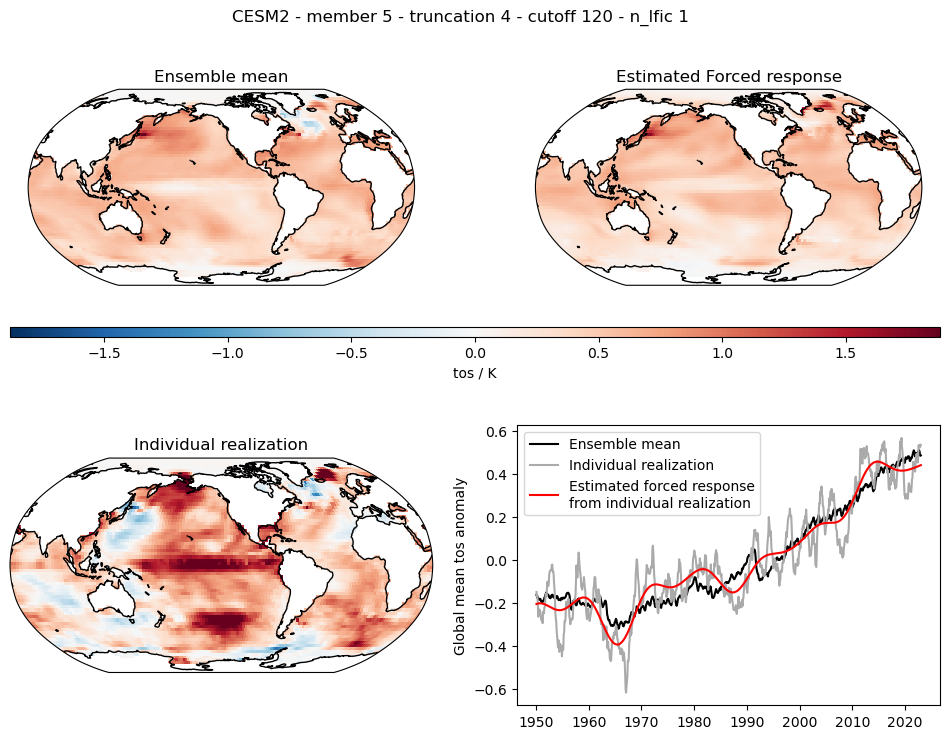

In [8]:
# vary these to play around
function_name = "simple_ica"
truncation = 4
cutoff = 120
n_lfic = 1  # number of ICs to retain for reconstruction; I think 1 is best
timestep_to_plot = -1
# rescale response so it matches low-pass filtered global mean values?
constrained_to_global_mean = True
#model = "MPI-ESM1-2-LR"
model = "CESM2"
members = sorted(list(anomaly_maps[model].keys()))
im = 4
member = members[im]
fig, ax = plot_estimate_and_true(
    model=model,
    member=member,
    function_name=function_name,
    ncvar=ncvar,
    truncation=truncation,
    cutoff=cutoff,
    n_lfic=n_lfic,
    constrained_to_global_mean=constrained_to_global_mean,
    timestep_to_plot=timestep_to_plot,
)

Some results from playing around with this:
- Number of ICs to reconstruct the forced response (`n_lfic`): Generally 1 seems to be the optimum. Adding more LFICs to reconstruct the forced response estimate makes it almost always worse.
- Low-pass filter cutoff (`cutoff`): the temporal variability of the estimated global mean response is way too high. This is worse for low cutoffs (obviously) but saturates for relatively high cutoffs and doesn't really improve. It seems that 120 months is a reasonable value.
- Number of PCs to retain in the PCA step of ICA (`truncation`): As discussed before, this is crucial. Too few or too many retained PCs heavily degrade the results. +/- 2 can already make a big difference, small numbers seem to be better
- Without re-scaling the forced response to match the low-pass filtered global mean time series of the input the results can be quite off. It seems that the re-scaling improves the estimate.

### Evaluation of hyperparameter optimization

It becomes clear from playing around with the results that the optimal number of IC/PC pairs to reconstruct the forced response (`'n_lfic`) is 1. Furthermore, the cutoff time for the low-pass filter (`cutoff`) should be around 120 months. Small variations around that value don't make a difference, going substantially lower degrades the results.

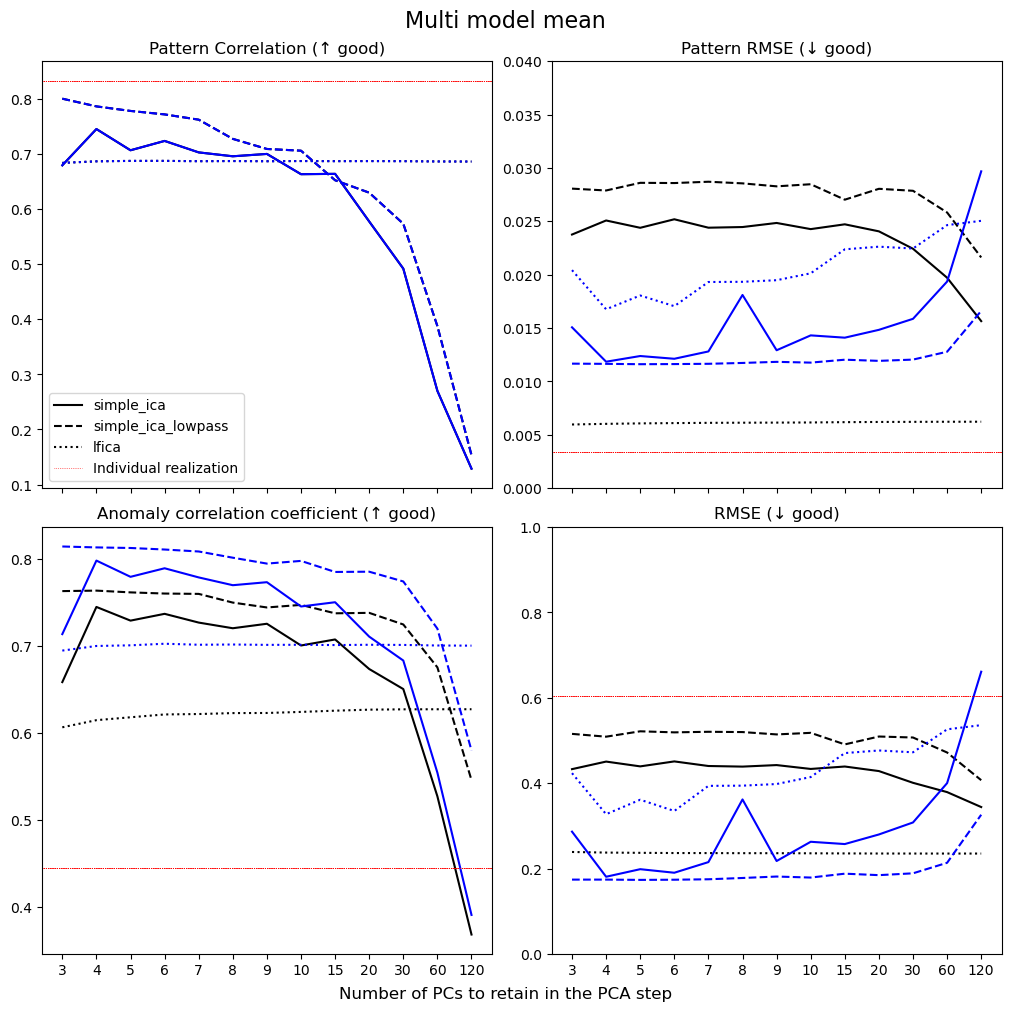

In [9]:
# Some parameters have clear optima from visual inspection of the results
ic = 2  # (i.e. cutoff = 120 months)
inl = 0  # (i.e. n_lfic = 1)
# colors = matplotlib.cm.get_cmap("copper", len(models))
linestyles = ("solid", "dashed", "dotted")
color = "k"
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, constrained_layout=True)
for reconstruction_method, label_rec, color in zip(
    ["forcedresponse", "forcedresponse_constrained_to_global_mean"],
    ["simple reconstruction", "reconstruction constrained to global mean"],
    ["black", "blue"],
):
    score_model_dic = {}
    for model in training_models:
        score_model_dic[model] = {
            var: np.load(
                os.path.join(
                    OUT_DIR,
                    "hyperparameter_optimization_scores",
                    training_tier,
                    reconstruction_method,
                    f"{model}_{var}.npy",
                )
            )
            for var in (
                "corr_trend",
                "corr_trend_raw",
                "mse_trend",
                "mse_trend_raw",
                "corr",
                "corr_raw",
                "mse",
                "mse_raw",
            )
        }
    # shape of results is [ifu, im, it, ic, inl]
    # function, member, truncation, cutoff, n_lfic
    score_dic = {
        var: np.mean(
            [score_model_dic[model][var] for model in score_model_dic.keys()], axis=0
        )
        for var in (
            "corr_trend",
            "corr_trend_raw",
            "mse_trend",
            "mse_trend_raw",
            "corr",
            "corr_raw",
            "mse",
            "mse_raw",
        )
    }
    for ifu, function in enumerate(functions):
        label_ind = (
            "Individual realization"
            if (ifu == len(functions) - 1 and reconstruction_method == "forcedresponse")
            else None
        )
        function_name = getattr(function, "__name__", str(function))
        label_rec = function_name if reconstruction_method == "forcedresponse" else None
        ls = linestyles[ifu]
        # [0, 0]: Pattern correlation
        ax[0, 0].plot(
            np.mean(score_dic["corr_trend"][ifu, :, :, ic, inl], axis=0),
            ls=ls,
            color=color,
            label=label_rec,
        )
        ax[0, 0].axhline(
            np.mean(score_dic["corr_trend_raw"]),
            lw=0.5,
            ls="dotted",
            color="red",
            label=label_ind,
        )
        # [0, 1]: Pattern RMSE
        ax[0, 1].plot(
            np.sqrt(np.mean(score_dic["mse_trend"][ifu, :, :, ic, inl], axis=0)),
            ls=ls,
            color=color,
        )
        ax[0, 1].axhline(
            np.sqrt(np.mean(score_dic["mse_trend_raw"])),
            lw=0.5,
            ls="dotted",
            color="red",
        )
        # [1, 0]: Anomaly correlation coefficient
        ax[1, 0].plot(
            np.mean(score_dic["corr"][ifu, :, :, ic, inl], axis=0),
            ls=ls,
            color=color,
        )
        ax[1, 0].axhline(
            np.mean(score_dic["corr_raw"]),
            lw=0.5,
            ls="dotted",
            color="red",
        )
        # [1, 1]: RMSE
        ax[1, 1].plot(
            np.sqrt(np.mean(score_dic["mse"][ifu, :, :, ic, inl], axis=0)),
            ls=ls,
            color=color,
        )
        ax[1, 1].axhline(
            np.sqrt(np.mean(score_dic["mse_raw"])),
            lw=0.5,
            ls="dotted",
            color="red",
        )

ax[0, 0].set_xticks(range(len(truncations)), truncations)
ax[0, 0].legend()
fig.supxlabel("Number of PCs to retain in the PCA step")
ax[0, 0].set_title("Pattern Correlation (↑ good)")
ax[0, 1].set_title("Pattern RMSE (↓ good)")
ax[1, 0].set_title("Anomaly correlation coefficient (↑ good)")
ax[1, 1].set_title("RMSE (↓ good)")
ax[0, 1].set_ylim(0, 0.04)
ax[1, 1].set_ylim(0, 1)
fig.suptitle(f"Multi model mean - {training_tier}", fontsize=16)

plt.show()

Fig.: Scores for the reconstruction of the forced response. Black lines represent the simple reconstruction method, blue lines the reconstruction constrained to the global mean.

No matter which model, the Pattern correlation and Pattern RMSE are worse than what you would get if you just looked at the individual realization. The anomaly correlation coefficient and RMSE are quite good with ICA. For the LFICA method, the results do not depend strongly on the number of PCs used (which is equal to the number of ICs) because it anyway produces a linear combination of ICs. For the other methods, it seems favorable to retain only a small number of PCs. Across metrics, the simple ICA seems to perform about as good as the ICA on the lowpass-filtered data when using a small number of retained PCs (i.e. near the optimum). The plot looks similar for all Tiers, although Tier3 obviously yields the worst results, because the period is shorter.

# Applying the method to the evaluation data

I pick the following hyperparameters:
- Number of ICs to reconstruct the forced response (`n_lfic`): 1
- Low-pass filter cutoff (`cutoff`): 120 months
- Number of PCs to retain in the PCA step of ICA (`truncation`): 4 for `simple_ica`, 3 for `simple_ica_lowpass`, 30 for `lfica` (doesn't really matter for `lfica`)

There are three methods (Simple ICA, Simple ICA with low-pass, and LFICA) and two forced response reconstruction methods (normal reconstruction, reconstruction constrained to global mean). From the analysis before it becomes clear that the simple ICA with and without low-pass performs best when reconstructing it constrained to the global mean, and the LFICA works best with the normal reconstruction. So we produce three estimates:
1. Simple ICA - reconstruction constrained to the global mean
1. Simple ICA with low-pass - reconstruction constrained to the global mean
1. LFICA - normal reconstruction

In [6]:
warnings.filterwarnings("error")

# I decide for the following hyperparameters
cutoff = 120  # cutoff (months) for the timeseries filtering
functions = (simple_ica, simple_ica_lowpass, lfica)
truncations = (4, 3, 30)  # number of PCs to retain in the PCA step
constrained_to_global_means = (True, True, False)


def read_evaluation_data(eval_tier, ncvar):
    """
    Load evaluation data from files and calculate monthly anomalies.

    Parameters
    ----------
    eval_tier : str
        'Tier1', 'Tier2' or 'Tier3'
    ncvar : str
        variable name

    Returns
    -------
    evaluation_anomaly_maps : dictionary of xarray DataArrays
        keys are the model names.

    """
    # period of time to consider data for training
    tv_time_period = eval_periods[eval_tier]
    # anomalies will be with respect to mean over entire period
    reference_period = tv_time_period

    epath = os.path.join(ROOT_DIR, f"Evaluation-{eval_tier}", cmipTable[ncvar], ncvar)
    efiles = glob.glob(os.path.join(epath, "*.nc"))
    efiles = sorted(efiles, key=natsort)

    # initialize dictionary to store data
    evaluation_anomaly_maps = {}
    missing_data_mask = {}
    vid = cmipVar[ncvar]

    # loop over evaluation files
    for im, fn in enumerate(efiles):
        # get evaluation identifier
        model = fn.split("/")[-1].split("_")[2].split(".")[0]
        # read in data for realization
        ts_3d = load_realization(fn, vid, tv_time_period, reference_period)
        # store anomaly map
        evaluation_anomaly_maps[model] = ts_3d
    return evaluation_anomaly_maps


def estimate_evaluation_members_response(
    da,
    model,
    function,
    truncation,
    cutoff,
    constrained_to_global_mean,
    ncvar,
    eval_tier,
):
    """
    Estimate ICs and IPs and reconstruct forced response of evaluation member.

    Parameters
    ----------
    da : xarray.core.dataarray.DataArray
        DataArray with the climate variable of interest
    model : str
        e.g. '1A', '1B', '1C', ...
    function : simple_ica, simple_ica_lowpass, or lfica
        Method for calculating the ICs/IPs
    truncation : int
        Number of EOFs to use in the PCA step of ICA.
    cutoff : int
        Cutoff time for the lowpass filter in months.
    constrained_to_global_mean : Bool
        Rescale to match low-pass filtered global mean time series of input variable.
    ncvar : str
    eval_tier : 'Tier1', 'Tier2' or 'Tier3'

    Returns
    -------
    None.

    """
    function_name = getattr(function, "__name__", str(function))
    try:
        ics, ips = function(
            da,
            cutoff=cutoff,
            truncation=truncation,
        )
        forced_response_estimate = reconstruct_forced_response(
            ics, ips, da, constrained_to_global_mean=constrained_to_global_mean
        )
        forced_response_estimate.to_netcdf(
            os.path.join(
                ROOT_DIR,
                "output",
                "forcedresponse_evaluation",
                function_name,
                f"{ncvar}_{model}_{eval_tier}_{function_name}_moritzguenther.nc",
            )
        )
    except sklearn.exceptions.ConvergenceWarning:
        print(f"{function_name} did not converge for {model}.")

In [ ]:
if True:
    for eval_tier, ncvars in eval_ncvars.items():
        for ncvar in ncvars:
            print(f"{eval_tier}: {ncvar}")
            print("   Reading files and calculating anomaly maps...")
            evaluation_anomaly_maps = read_evaluation_data(eval_tier, ncvar)
            models = evaluation_anomaly_maps.keys()
            n_cpus = min(len(functions) * len(models), mp.cpu_count())
            print("   Estimating forced response...")
            with mp.Pool(n_cpus) as p:
                p.starmap(
                    estimate_evaluation_members_response,
                    [
                        (
                            da,
                            model,
                            function,
                            truncation,
                            cutoff,
                            constrained_to_global_mean,
                            ncvar,
                            eval_tier,
                        )
                        for (model, da), (
                            function,
                            truncation,
                            constrained_to_global_mean,
                        ) in itertools.product(
                            evaluation_anomaly_maps.items(),
                            zip(functions, truncations, constrained_to_global_means),
                        )
                    ],
                )

In [17]:
eval_tier = "Tier1"
ncvar = "zmta"
truncation = 4
function = simple_ica
cutoff = 120
constrained_to_global_mean = True
evaluation_anomaly_maps = read_evaluation_data(eval_tier, ncvar)
models = evaluation_anomaly_maps.keys()
model = "1B"
da = evaluation_anomaly_maps[model]


### Plot forced response pattern estimates
for tos and psl for all methods, all evaluation members of the chosen Tier

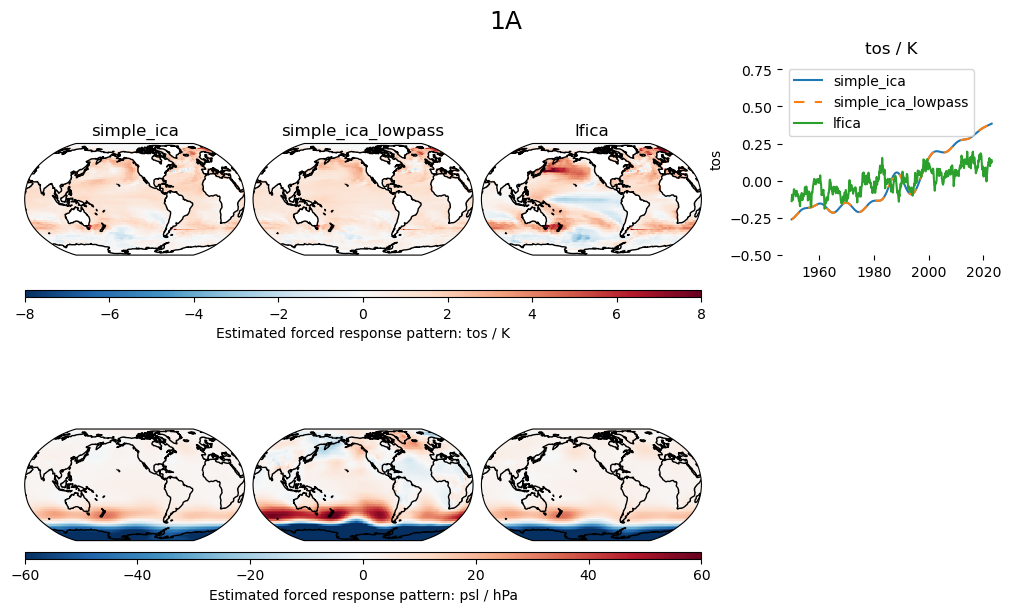

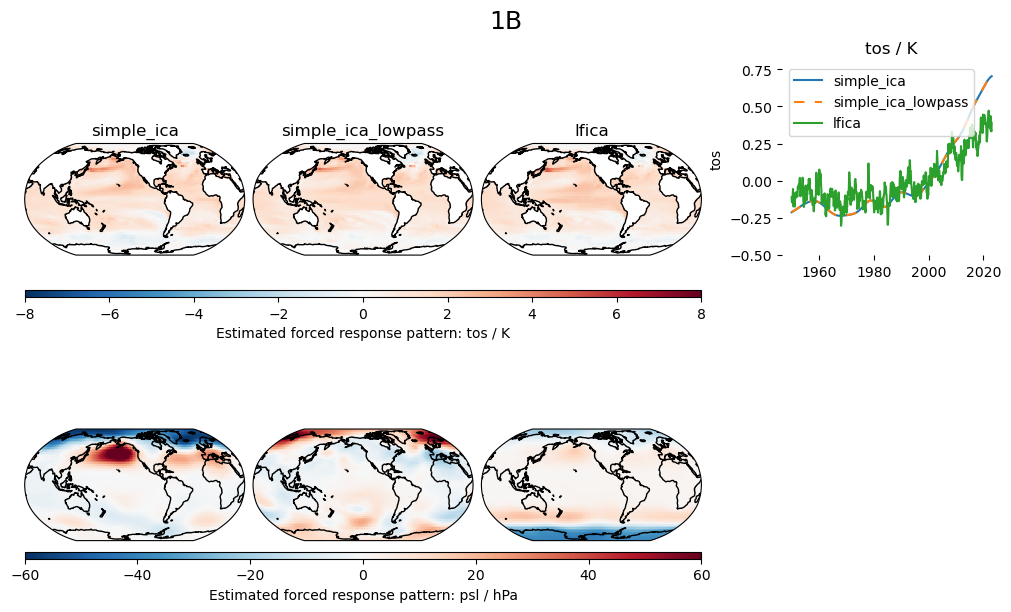

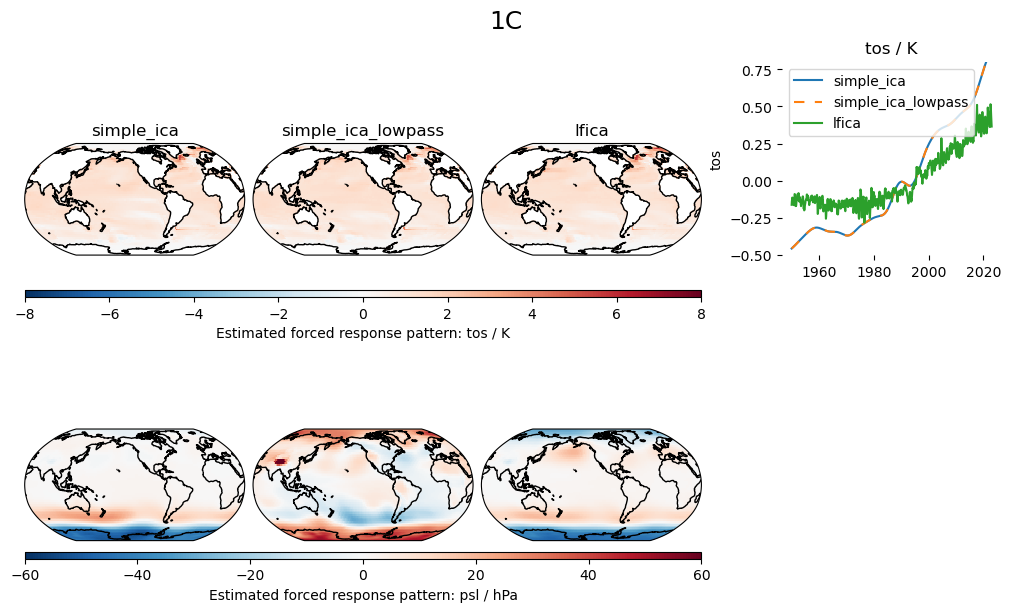

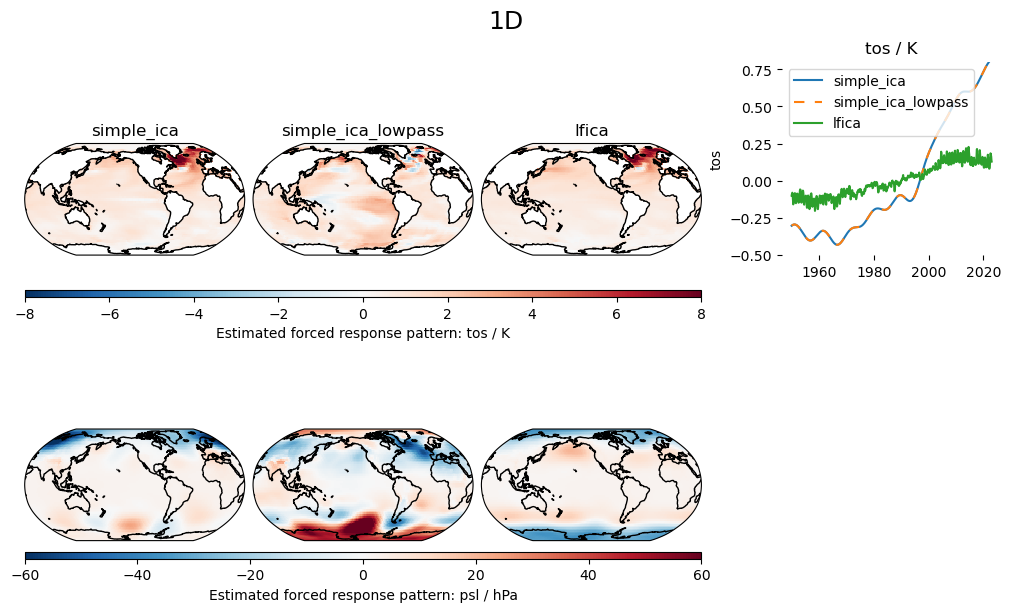

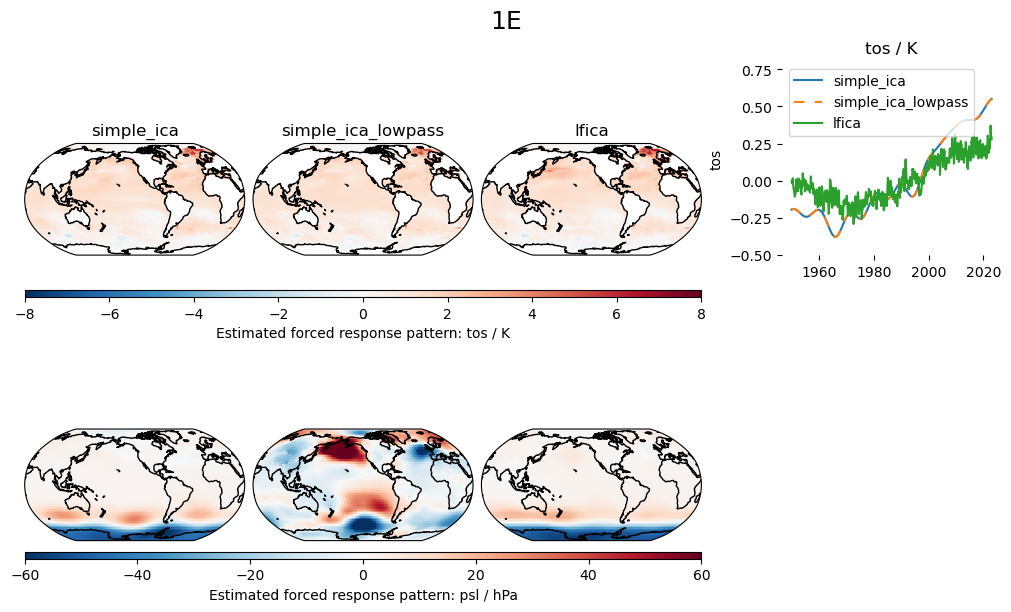

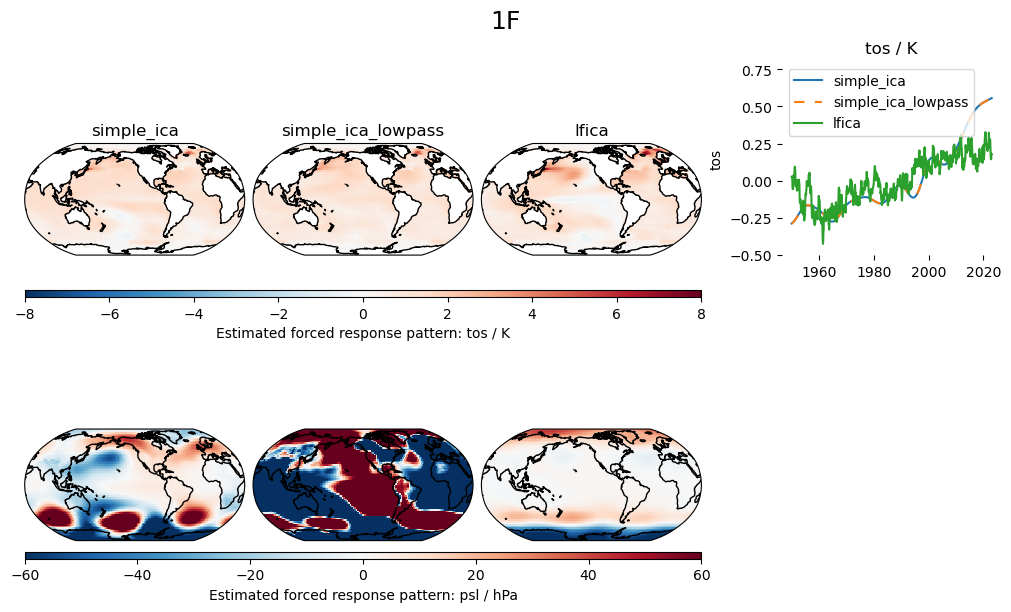

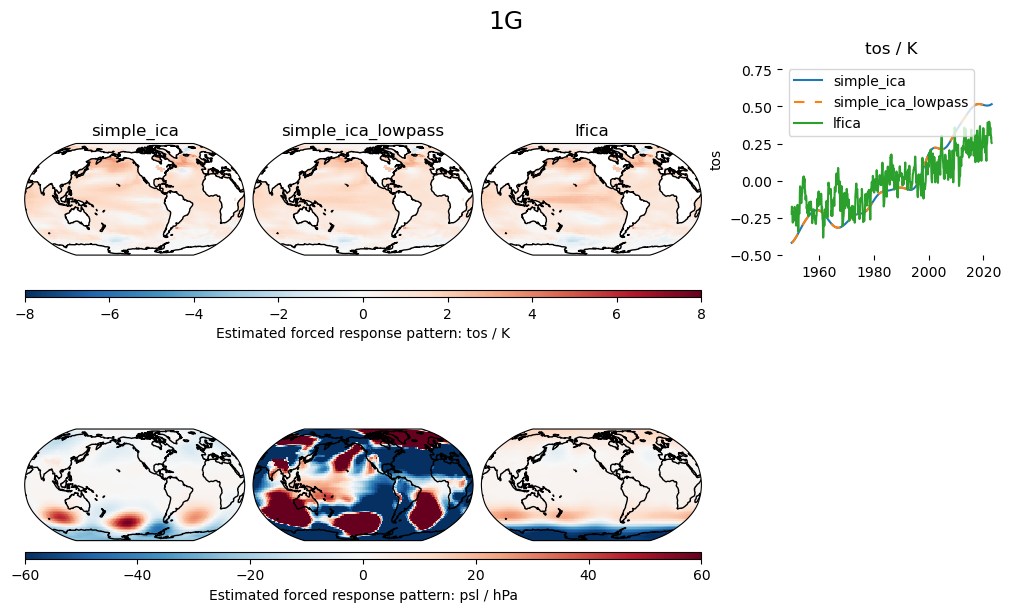

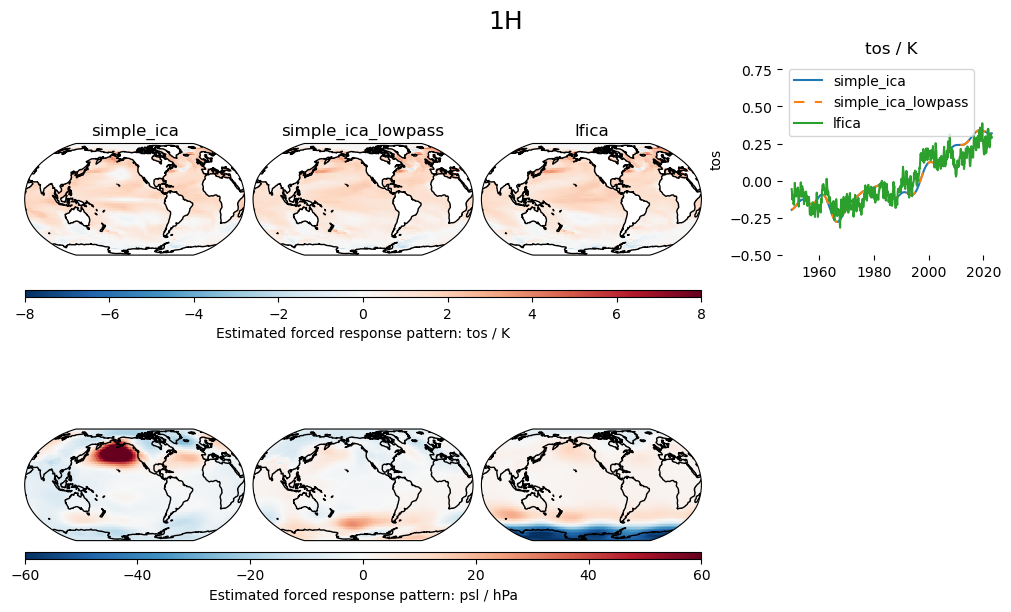

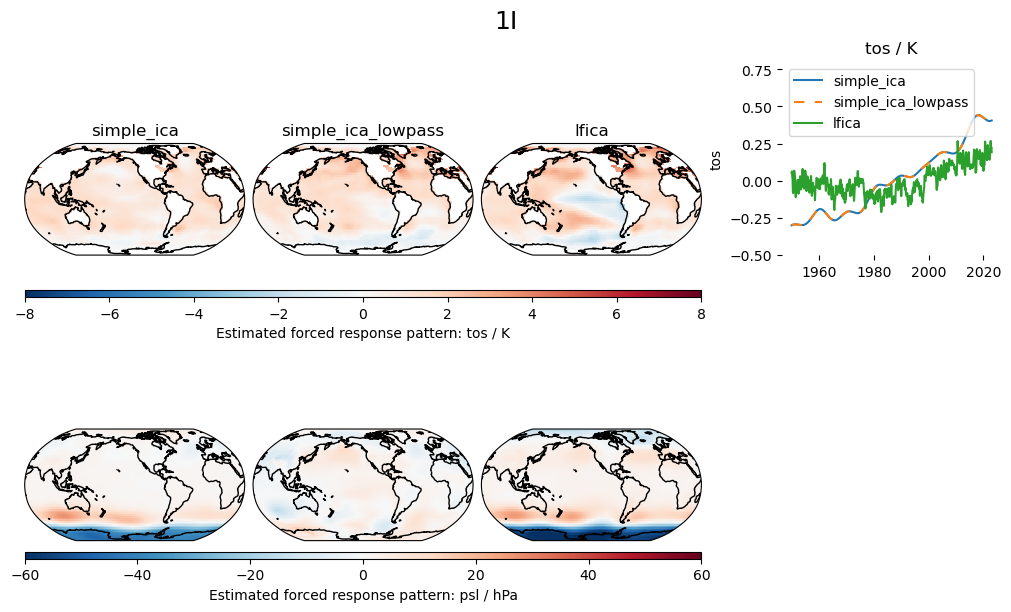

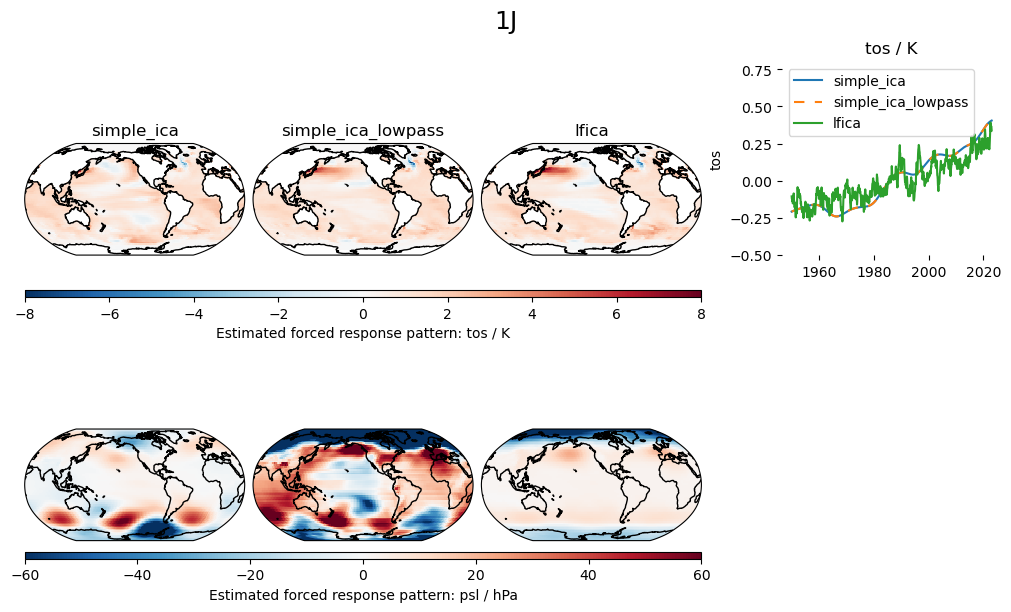

In [9]:
eval_tier = "Tier1"
vmin_tos = -8
vmax_tos = 8
vmin_psl = -60
vmax_psl = 60
cmap = matplotlib.colormaps["RdBu_r"]
evaluation_models = [
    f"{eval_tier[-1]}{letter}"
    for letter in ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")
]
for model in evaluation_models:
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    ax1 = fig.add_subplot(
        241,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax2 = fig.add_subplot(
        242,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax3 = fig.add_subplot(
        243,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax4 = fig.add_subplot(244, frameon=False)
    ax5 = fig.add_subplot(
        245,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax6 = fig.add_subplot(
        246,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax7 = fig.add_subplot(
        247,
        projection=ccrs.Robinson(central_longitude=230),
        transform=ccrs.PlateCarree(central_longitude=230),
        frameon=True,
    )
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    for ifu, function in enumerate(functions):
        function_name = getattr(function, "__name__", str(function))
        ls = "solid" if not function_name == "simple_ica_lowpass" else (0, (5, 5))
        forced_response_estimate_tos = xr.open_dataset(
            os.path.join(
                ROOT_DIR,
                "output",
                "forcedresponse_evaluation",
                function_name,
                f"tos_{model}_{eval_tier}_{function_name}_moritzguenther.nc",
            )
        )["tos"]
        forced_response_estimate_psl = (
            xr.open_dataset(
                os.path.join(
                    ROOT_DIR,
                    "output",
                    "forcedresponse_evaluation",
                    function_name,
                    f"psl_{model}_{eval_tier}_{function_name}_moritzguenther.nc",
                )
            )["psl"]
            / 1e2
        )
        da_weights_tos = da_gridarea.where(forced_response_estimate_tos.notnull())
        da_weights_tos /= da_weights_tos.sum(["lon", "lat"])
        da_weights_psl = da_gridarea.where(forced_response_estimate_tos.notnull())
        da_weights_psl /= da_weights_psl.sum(["lon", "lat"])
        gl_mean_tos = (forced_response_estimate_tos * da_weights_tos).sum(
            ["lon", "lat"]
        )
        gl_mean_psl = (forced_response_estimate_psl * da_weights_psl).sum(
            ["lon", "lat"]
        )
        pattern_tos = forced_response_estimate_tos.isel(time=0) / gl_mean_tos.isel(
            time=0
        )
        pattern_psl = forced_response_estimate_psl.isel(time=0) / gl_mean_psl.isel(
            time=0
        )
        pc_tos = pattern_tos.plot(
            ax=ax[ifu],
            transform=ccrs.PlateCarree(),
            vmin=vmin_tos,
            vmax=vmax_tos,
            cmap=cmap,
            add_colorbar=False,
        )
        ax4.plot(gl_mean_tos.time, gl_mean_tos, ls=ls, label=function_name)
        ax4.set_ylim(-0.5, 0.8)
        ax4.set_title("tos / K")
        pc_psl = pattern_psl.plot(
            ax=ax[ifu + 4],
            transform=ccrs.PlateCarree(),
            vmin=vmin_psl,
            vmax=vmax_psl,
            cmap=cmap,
            add_colorbar=False,
        )
        ax[ifu].set_title(function_name)
        ax[ifu + 4].set_title("")
        ax[ifu].coastlines()
        ax[ifu + 4].coastlines()
    ax4.legend()
    ax4.set_ylabel(ncvar)
    fig.colorbar(
        pc_tos,
        ax=ax[0:3],
        orientation="horizontal",
        aspect=100,
        label="Estimated forced response pattern: tos / K",
    )
    fig.colorbar(
        pc_psl,
        ax=ax[4:7],
        orientation="horizontal",
        aspect=100,
        label="Estimated forced response pattern: psl / hPa",
    )
    fig.suptitle(model, fontsize=18)
    plt.show()

Fig.: Forced response estimates of `tos` and `psl` variable for all evaluation models. For `tos`, the global mean time series is shown as well. When using the `simple_ica` and `simple_ica_lowpass` methods, I chose the reconstruction constrained to global mean, which is why their global mean time series are equal by construction. The `slp` patterns differ wildly between the methods, which I think is related to the fact that my methods might not work so well for variables that don't have a global mean trend.